# Implementation



In [1]:
import collections
import datetime
import glob
import pathlib
import pandas as pd
import seaborn as sns
# import tensorflow as tf
import os
import numpy as np
import scipy.signal as signal
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
from IPython import display
from IPython import display
from matplotlib import pyplot as plt
from typing import Optional
from pathlib import Path
import numpy as np
import torch.utils.data
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from torch.autograd import Variable
import torch
import numpy as np
from scipy import signal

def plot_specgram(waveform, sample_rate):
    f, t, Sxx = signal.spectrogram(waveform, sample_rate)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

In [2]:
import torchaudio
# noise_whole = r"/data/ephraim/datasets/known_noise/undiff/exp_ar_j_real_2sec_divided/noises/machine.wav"
# noise_whole, sr = torchaudio.load(noise_whole)

import numpy as np
import torch


def normalize_tensor(tensor):
    """
    Normalize the input tensor using Z-score normalization.
    
    Args:
        tensor (torch.Tensor): Input tensor to be normalized.
        
    Returns:
        normalized_tensor (torch.Tensor): The normalized tensor.
        mean (float): Mean of the input tensor.
        std (float): Standard deviation of the input tensor.
    """
    mean = tensor.mean()
    std = tensor.std()
    
    # Avoid division by zero
    std = std if std > 0 else 1e-6
    
    normalized_tensor = (tensor - mean) / std
    return normalized_tensor, mean, std


def denormalize_tensor(normalized_tensor, mean, std):
    """
    Recover the original tensor from the normalized tensor.
    
    Args:
        normalized_tensor (torch.Tensor): Normalized tensor.
        mean (float): Mean used for normalization.
        std (float): Standard deviation used for normalization.
    
    Returns:
        torch.Tensor: The original tensor.
    """
    return normalized_tensor * std + mean


def create_ar_noise(n_samples, ar_coefs,order=1, dtype=torch.float32):
    
    mu=0
    sigma=1
    # Generate white noise
    white_noise = np.random.normal(mu, sigma, n_samples + order)

    # Initialize AR coefficients randomly
    # ar_coefs = np.random.uniform(AR_COEF_MIN,AR_COEF_MAX, order)

    # Generate AR noise
    ar_noise = np.zeros_like(white_noise)
    for i in range(order, n_samples + order):
        ar_noise[i] = np.dot(ar_coefs, ar_noise[i - order:i]) + white_noise[i]
    ar_noise = ar_noise[order:]  # Discard initial transient
    return torch.from_numpy(ar_noise).to(dtype).view(1,-1)
# ar_noise1 = create_ar_noise(16000, 0.9, 0.9)


sr=16000
# noise_whole = create_ar_noise(10000000, 0.9, 0.9, 1)
def create_ar_noise_batch(batch_size, n_samples, ar_coefs, order=1, sigma=1, dtype=torch.float32):
    """
    Efficiently generate a batch of AR noise samples using matrix operations.
    
    Parameters:
        batch_size (int): Number of AR noise samples in the batch.
        n_samples (int): Length of each AR noise sample.
        AR_COEF_MIN (float): Minimum value for AR coefficients.
        AR_COEF_MAX (float): Maximum value for AR coefficients.
        order (int): The order of the AR process.
        dtype (torch.dtype): The desired PyTorch tensor data type.

    Returns:
        torch.Tensor: Batch of AR noise samples with shape (batch_size, n_samples).
    """
    # Initialize white noise for the entire batch
    white_noise = torch.normal(0, 1, size=(batch_size, n_samples + order), dtype=dtype)

    # Convert AR coefficients to a tensor if needed
    if not isinstance(ar_coefs, torch.Tensor):
        ar_coefs = torch.tensor(ar_coefs, dtype=dtype)
    
    # Ensure AR coefficients are of the correct order
    assert ar_coefs.shape[0] == order, f"AR coefficients must have length {order}."
    
    # Expand AR coefficients for batch processing
    ar_coefs = ar_coefs.unsqueeze(0).expand(batch_size, -1)  # Shape: (batch_size, order)


    # Initialize the AR noise tensor
    ar_noise = torch.zeros_like(white_noise)

    # Iterate across time steps to compute AR noise
    for t in range(order, n_samples + order):
        # Slice the relevant previous values for all samples
        past_values = ar_noise[:, t - order:t]  # Shape: (batch_size, order)
        # Compute AR noise using matrix multiplication
        ar_noise[:, t] = (past_values * ar_coefs).sum(dim=1) + sigma*white_noise[:, t]

    # Remove the first `order` values to discard transient
    return ar_noise[:, order:]




In [3]:
21*16000

336000

In [4]:
#### Display tools
def plot_this(s,title=''):
    """

    """
    import pylab
    s = s.squeeze()
    if s.ndim ==1:
        pylab.plot(s)
    else:
        pylab.imshow(s,aspect='auto')
        pylab.title(title)
    pylab.show()

In [5]:
dataset_size=1*1
n_samples =64000
# ar_coefs = [ 0.4,-0.1, 0.1, -0.05,0.03]
ar_coefs = [0.9]
# ar_noise_batch = create_ar_noise_batch(batch_size=dataset_size, n_samples=n_samples, ar_coefs=[-0.9], order=1)
ar_noise_batch = create_ar_noise_batch(batch_size=dataset_size, n_samples=n_samples, ar_coefs=ar_coefs,sigma=3, order=len(ar_coefs))

# ar_noise_batch, mean_all, std_all = normalize_tensor(ar_noise_batch)

sr = 16000
new_sample_rate = 16000
# resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=new_sample_rate)
# noise_whole = resampler(noise_whole)
# print("old sr:", sr)
# print("new sr:", new_sample_rate)

print(ar_noise_batch.shape)
stop = 3
noise_sample1 = ar_noise_batch[0,  int(0*sr):int(stop*sr)]
noise_sample2 = ar_noise_batch[0,  int(stop*sr):int((stop+1)*sr)]
train_ar = ar_noise_batch[:,  int(0*sr):int(stop*sr)]
test_ar = ar_noise_batch[:,  int(stop*sr):int((stop+1)*sr)]
print(noise_sample1.shape)
print(noise_sample2.shape)

torch.Size([1, 64000])
torch.Size([48000])
torch.Size([16000])


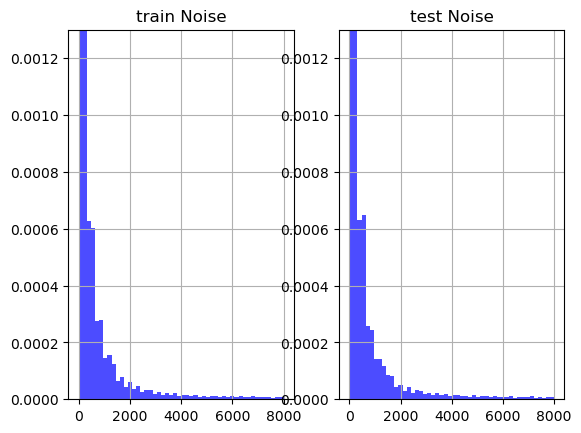

In [141]:



freqs1, magnitudes1 = signal.welch(noise_sample1.squeeze().cpu().numpy(), fs=16000)
freqs, magnitudes = signal.welch(noise_sample2.squeeze().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('train Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('test Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

# Data Processing & Preparation.

In [142]:
import torch
from torch.utils.data import DataLoader, TensorDataset


# Create datasets and data loaders
train_tensor = torch.tensor(train_ar, dtype=torch.float32)#.view(1,1,-1)
test_tensor = torch.tensor(test_ar, dtype=torch.float32)#.view(1,1,-1)
train_tensor.shape


/tmp/ipykernel_1019688/1243974303.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = torch.tensor(train_ar, dtype=torch.float32)#.view(1,1,-1)
/tmp/ipykernel_1019688/1243974303.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = torch.tensor(test_ar, dtype=torch.float32)#.view(1,1,-1)


torch.Size([1, 48000])

In [143]:

def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear": ###chosen in default
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        # scale = 1000 / num_diffusion_timesteps
        beta_start = 0.0001  # scale * 0.0001
        beta_end = 0.02  # scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )

betas=get_named_beta_schedule("linear", 200)

alphas = 1.0 - betas
alphas_cumprod =  torch.from_numpy(np.cumprod(alphas, axis=0))
white_noise_diffusion = torch.normal(0,1,train_tensor.shape)
white_noise_diffusion2 = torch.normal(0,1,test_tensor.shape)
g_t = torch.sqrt((1-alphas_cumprod)/(alphas_cumprod))
t = np.random.randint(1,200,1)
cur_g_t = g_t[t]
real_Vtrain = train_tensor + white_noise_diffusion*g_t[t]
real_Vtest = test_tensor + white_noise_diffusion2*g_t[t]
# train_tensor = real_Vtrain
# test_tensor = real_Vtest
real_Vtrain.shape


torch.Size([1, 48000])

In [144]:
# train_full_tensors = train_tensor.squeeze().repeat(200,1,1).view(dataset_size,200,-1)
train_full_tensors = train_tensor.squeeze().view(dataset_size,1,-1)

# train_full_tensors = train_tensor.reshape(dataset_size,200,-1)

for i in [0]:
    cur_white_noise_diffusion = torch.normal(0,1,train_full_tensors[:,i,:].shape)
    train_full_tensors = train_full_tensors[:,i,:]#+cur_white_noise_diffusion*g_t[199]

# test_full_tensors = test_tensor.squeeze().repeat(200,1).view(200,1,-1)
test_full_tensors = test_tensor.squeeze().view(dataset_size,1,-1)

for i in [0]:
    cur_white_noise_diffusion = torch.normal(0,1,test_full_tensors[:,i,:].shape)
    test_full_tensors = test_full_tensors[:,i,:] #+cur_white_noise_diffusion*g_t[199]

print(train_full_tensors.shape)
print(test_full_tensors.shape)

torch.Size([1, 48000])
torch.Size([1, 16000])


In [145]:
import os
import pandas as pd
from torch.utils.data import Dataset


class NoiseDataset(Dataset):
    def __init__(self, data_tensor, gt_tensor):
        self.data_tensor =data_tensor
        self.gt_tensor = gt_tensor

    def __len__(self):
        return self.data_tensor.shape[0]

    def __getitem__(self, idx):
        item = self.data_tensor[idx,:,:]
        cur_gt = self.gt_tensor[idx]
        return item, cur_gt

class BatchNoiseDataset(Dataset):
    def __init__(self, data_tensor, gt_tensor):
        self.data_tensor =data_tensor
        self.gt_tensor = gt_tensor

    def __len__(self):
        return self.data_tensor.shape[0]

    def __getitem__(self, idx):
        item = self.data_tensor[idx,:,:]
        cur_gt = self.gt_tensor
        return item, cur_gt


In [146]:
def calc_stft(tensor):

    # Parameters
    sample_rate = 16000  # Sample rate in Hz
    n_fft = 512  # Number of FFT points
    win_length = n_fft  # Window length
    hop_length = int(win_length/2)  # Number of samples between frames
    window = torch.hann_window(win_length)  # Window function

    signal_ = tensor.view(-1)
    duration = max(tensor.shape)

    stft = torch.stft(signal_, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, return_complex=True)
    return stft, duration, sample_rate

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    
from scipy.signal import firwin
def fir_filter(tensor, high=False, cutoff=6000,num_taps=101,device="cpu",sample_rate=16000):
    cutoff_freq = cutoff  # Cutoff frequency for the high-pass filter in Hz
    num_taps = num_taps  # Filter order (number of filter coefficients)
    if high:
        pass_zero = False
    else:
        pass_zero = True
    coefficients = firwin(num_taps, cutoff=cutoff_freq, pass_zero=pass_zero, fs=sample_rate)

    # Convert filter coefficients to a PyTorch tensor
    coefficients = torch.tensor(coefficients, dtype=torch.float32).to(device)

    pad_length = (num_taps - 1) // 2
    signal_padded = torch.nn.functional.pad(tensor.view(1, 1, -1), (pad_length, pad_length), mode='constant').to(device)

    # Apply the FIR filter to the signal using convolution
    filtered_signal = torch.nn.functional.conv1d(signal_padded.view(1, 1, -1), coefficients.view(1, 1, -1))
    return filtered_signal

In [147]:
import torch
from torch import nn
def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs):
   pad = (kernel_size - 1) * dilation +1
   return nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)

class CausalConv1dClass(nn.Conv1d):
    def __init__(self,in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        pad = (kernel_size - 1) * dilation +1
        super().__init__(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)
    
    def forward(self, inputs):
        output = super().forward(inputs)
        if self.padding[0] != 0:
            output = output[:, :, :-self.padding[0]-1]
        return output


class NetworkDivided(nn.Module):
    def __init__(self, kernel_size=25):
        super().__init__()   
        self.conv0 = CausalConv1dClass(1, 2, kernel_size=kernel_size, dilation=10)
        self.tanh0 = nn.Tanh()
        self.tanh0_1 = nn.Tanh()
        self.sig0 = nn.Sigmoid()
        self.conv1 = CausalConv1dClass(1, 2, kernel_size=kernel_size, dilation=1)
        self.tanh = nn.Tanh()
        self.tanh1_1 = nn.Tanh()
        self.sig1 = nn.Sigmoid()
        self.conv2 = CausalConv1dClass(2, 2, kernel_size=kernel_size, dilation=2)
        self.tanh2 = nn.Tanh()
        self.tanh2_1 = nn.Tanh()
        self.sig2 = nn.Sigmoid()
        self.conv3 = CausalConv1dClass(2, 2, kernel_size=kernel_size, dilation=4)
        self.tanh3 = nn.Tanh()
        self.tanh3_1 = nn.Tanh()
        self.sig3 = nn.Sigmoid()
        self.conv4 = CausalConv1dClass(2, 2, kernel_size=kernel_size, dilation=8)
        self.param = nn.Parameter(torch.randn(1))
        
        # fc_layer = nn.Linear(in_features=128, out_features=64)

    def forward(self, x, cur_gt):
        input = x[:]
        x1 = self.conv0(x)
        
        x = self.conv1(x)
        # gate, filter = torch.chunk(x, 2, dim=1)
        # x = torch.tanh(filter) * torch.sigmoid(gate)

        identity=x[:]
        x = x+x1
        x = self.tanh(x)
        x = self.conv2(x)
        # gate, filter = torch.chunk(x, 2, dim=1)
        # x = self.tanh0_1(filter) * self.sig0(gate)

        identity2=x[:]
        x = identity+x
        x = self.tanh2(x)
        x = self.conv3(x)
        # gate, filter = torch.chunk(x, 2, dim=1)
        # x =  self.tanh1_1(filter) * self.sig1(gate)

        identity3=x[:]
        x = x+identity2+identity
        x = self.tanh3(x)
        x = self.conv4(x)
        # gate, filter = torch.chunk(x, 2, dim=1)
        # x =  self.tanh2_1(filter) * self.sig2(gate)

        x = x+identity2+identity+identity3

        means = x[:,0,:]
        log_var = x[:,1,:]
        stds = torch.exp(0.5 *log_var)
        # print(input.reshape(1,-1).shape)
        # print(means.shape)
        # stds = calculate_rolling_std_with_means(input.reshape(1,-1), means, window_size=25)
        return means, stds
    
    def calc_model_likelihood(self, expected_means, expected_stds, wav_tensor, verbose=False):
        wav_tensor = wav_tensor.squeeze()
        means_=expected_means.squeeze()
        stds_ = expected_stds.squeeze()

        exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
        param_all = 1/(np.sqrt(2*np.pi)*stds_)
        model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
        model_likelihood2 = torch.sum(exp_all, axis=-1) 

        if verbose:
            print("model_likelihood1: ", model_likelihood1)
            print("model_likelihood2: ", model_likelihood2)
        
            
        return model_likelihood1 + model_likelihood2
    
    def casual_loss(self, expected_means, expected_stds, wav_tensor):
        model_likelihood = self.calc_model_likelihood(expected_means, expected_stds, wav_tensor)
        loss3 = torch.sum(expected_stds,axis=-1)
        return -model_likelihood + self.param*loss3/wav_tensor.shape[-1]

In [148]:
loss_array = {}
loss_test_array = {}
from torch import optim

def train(nets, steps,train_loader,test_loader,epochs ,device):
    
    print("start ")
    for i in steps:
        model = nets[i]
        min_test_loss = 1000000000
        # if i ==1:
        #     break
        #Create TensorDatasets
        
        model.to(device)
        model.train()
        ii=0
        optimizer = optim.Adam(model.parameters())
        for epoch in tqdm(range(epochs)):
            running_loss = 0.0
            for batch_idx, (batch_tensor, gt_tensor) in enumerate(train_loader):
                ii+=1
                # data = data[0]
                # for data in train_loader:
                optimizer.zero_grad()
                batch_tensor = batch_tensor.to(device, dtype=torch.float)
                gt_tensor = gt_tensor.to(device, dtype=torch.float)
                
                means, stds = model(batch_tensor,gt_tensor )


                # print(model.casual_loss)
                loss = model.casual_loss( means, stds, wav_tensor=batch_tensor).mean() ##.mean()
                # print("loss ",loss)
                # print("loss",loss)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                    
            # if epoch%50==0:
            #     # print(epoch)
            if epoch%1==0 or i > 90:
                with torch.no_grad():
                    for batch_idx, (test_inputs, gt_test) in enumerate(test_loader):
                        # test_inputs, gt_test = test_dataset.__getitem__(i)
                        # test_inputs = fir_filter(test_inputs,high=True)
                        test_inputs = test_inputs.to(device, dtype=torch.float)
                        gt_test = gt_test.to(device, dtype=torch.float)
                        meanst, stdst = model(test_inputs, gt_test)
                loss_t = model.casual_loss( meanst, stdst, wav_tensor=test_inputs).mean()
                if i in loss_test_array:
                    loss_test_array[i].append(float(loss_t))
                else:
                    loss_test_array[i] = [float(loss_t)]
                if loss_t<=min_test_loss or epoch<10:
                    min_test_loss = loss_t
                # else:
                #     break
            

            if i in loss_array:
                loss_array[i].append(float(loss))
            else:
                loss_array[i] = [float(loss)]
        nets[i].parameters = model.parameters
        print(f"Model {i} Epoch {epoch+1}/{epochs}, Loss: {running_loss}, test Loss: {loss_t}")
    print(ii)
    return nets, loss_array, loss_test_array

In [149]:
def compare_spectrograms(original,modified):
    train_tensor_ftft, duration, sample_rate= calc_stft(original)
    filtered_signal_ftft,duration, sample_rate = calc_stft(modified)
    train_tensor_ftft = torch.abs(train_tensor_ftft)
    filtered_signal_ftft = torch.abs(filtered_signal_ftft)
    limit = sample_rate/2

    figure, axis = plt.subplots(1,2)
    vmin = np.vstack([train_tensor_ftft.squeeze(),filtered_signal_ftft.squeeze()]).min()
    vmax = np.vstack([train_tensor_ftft.squeeze(),filtered_signal_ftft.squeeze()]).max()
    im = axis[0].imshow(train_tensor_ftft, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax, extent=[0, duration, 0, sample_rate / 2])
    axis[0].set_title('original Noise')
    axis[0].grid(True)
    axis[0].set_ylim(0.0, limit)
    axis[1].imshow(filtered_signal_ftft, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax, extent=[0, duration, 0, sample_rate / 2])
    axis[1].set_title('model Noise')
    axis[1].grid(True)
    axis[1].set_ylim(0.0, limit)
    figure.colorbar(im,ax=axis.ravel().tolist(), label='Magnitude')
    plt.show()

In [150]:
import matplotlib.pyplot as plt

def plot_loss(loss_array,loss_test_array,j):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(loss_array[j])
    axs[0].set_title('loss_array')
    axs[1].plot(loss_test_array[j])
    axs[1].set_title('loss_test_array')

In [151]:

torch.cuda.empty_cache()

In [152]:
device = "cuda:3"

start 


/tmp/ipykernel_1019688/2719055260.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Model 0 Epoch 1000/1000, Loss: 123221.765625, test Loss: 41007.625
1000


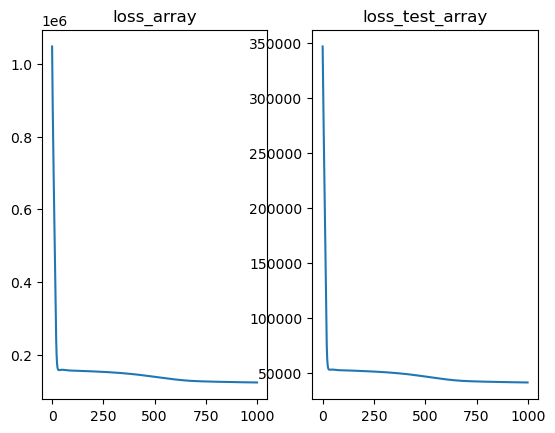

In [153]:
import torch.optim as optim
from network_factory import NetworkNoise6

nets = [NetworkNoise6() for i in range(200)]
epochs = 1000
device = "cuda:3"

loss_array = {}
loss_test_array = {}
i=0
train_dataset = BatchNoiseDataset(train_full_tensors.reshape(dataset_size,1,-1),g_t[i])
test_dataset = BatchNoiseDataset(test_full_tensors.reshape(dataset_size,1,-1),g_t[i])

#Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True) #todo: numbers
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)


nets,loss_array,loss_test_array = train(steps=[0],nets=nets,train_loader=train_loader,test_loader=test_loader,epochs=epochs,device=device)#nets, steps,train_loader,test_loader,epochs

plot_loss(loss_array,loss_test_array,0)

In [154]:
model=nets[0]
model.eval()

NetworkNoise6(
  (blocks): ModuleList(
    (0): Sequential(
      (0): CausalConv1dClassS(1, 8, kernel_size=(9,), stride=(1,), padding=(8,))
      (1): Tanh()
    )
    (1): Sequential(
      (0): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(2,))
      (1): Tanh()
    )
    (2): Sequential(
      (0): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(32,), dilation=(4,))
      (1): Tanh()
    )
    (3): Sequential(
      (0): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(8,))
      (1): Tanh()
    )
    (4): Sequential(
      (0): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(8,))
      (1): Tanh()
    )
    (5): Sequential(
      (0): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(2,))
      (1): Tanh()
    )
    (6): Sequential(
      (0): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(32,), dilation=(4,))
      (1): Tanh()
    )

In [155]:
model.to(device)

NetworkNoise6(
  (blocks): ModuleList(
    (0): Sequential(
      (0): CausalConv1dClassS(1, 8, kernel_size=(9,), stride=(1,), padding=(8,))
      (1): Tanh()
    )
    (1): Sequential(
      (0): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(2,))
      (1): Tanh()
    )
    (2): Sequential(
      (0): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(32,), dilation=(4,))
      (1): Tanh()
    )
    (3): Sequential(
      (0): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(8,))
      (1): Tanh()
    )
    (4): Sequential(
      (0): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(8,))
      (1): Tanh()
    )
    (5): Sequential(
      (0): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(2,))
      (1): Tanh()
    )
    (6): Sequential(
      (0): CausalConv1dClassS(8, 8, kernel_size=(9,), stride=(1,), padding=(32,), dilation=(4,))
      (1): Tanh()
    )

In [156]:


for batch_idx, (train_inputs, gt_test) in enumerate(train_loader):
    break
# test_inputs, gt_test = test_dataset.__getitem__(j)
train_inputs = train_inputs.to(device, dtype=torch.float)

with torch.no_grad():
    output_train_inputs_mean, output_train_inputs_std = (model(train_inputs, "gt_test"))
    
# with torch.no_grad():

In [157]:
l = 100000
output_train = model(train_full_tensors.view(1,1,-1)[:,:,1000:l].to(device),g_t[0].to(device))
mu, log_sig = output_train
loss_train = model.casual_loss( mu, log_sig, train_full_tensors.view(1,1,-1)[:,:,1000:l].to(device), offset=False)
loss_train

tensor(121312.6250, device='cuda:3', grad_fn=<NegBackward0>)

tensor(41667.3984, device='cuda:3', grad_fn=<NegBackward0>)


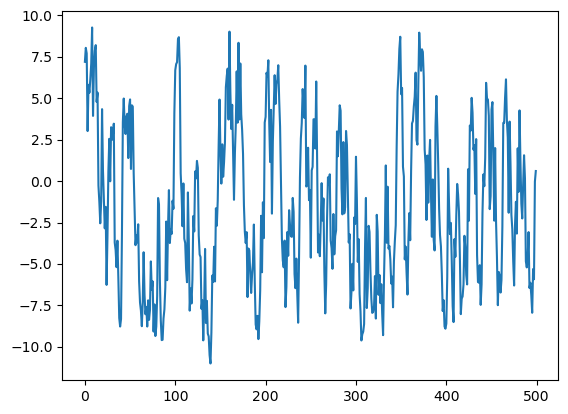

In [158]:
output = model(test_full_tensors.view(1,1,-1).to(device),g_t[0].to(device))
mu, log_sig = output
loss = model.casual_loss( mu, log_sig, test_full_tensors.view(1,1,-1).to(device), offset=False)
print(loss)
plot_this(output[0][:,0:500].cpu().detach().numpy())

In [159]:
j=0

In [160]:
long = 2000
window = 20000
mu_array = torch.zeros((long+window+1))
sig_array = torch.zeros((long+window+1))

model = model.to(device)
cur_input = train_inputs[:,:,:35000].clone().view(1,1,-1)
cur_input[0,0,window+1:] = 0
print(cur_input[0,0,window])
print(cur_input[0,0,window+1])
cur_input = cur_input.to(device, dtype=torch.float)
print(cur_input.shape)
with torch.no_grad():
# cur_input = cur_train[0,0,:window].view(1,1,-1)
    for i in tqdm(range(train_inputs.shape[2]-window)):
        if i >long:
            continue

        mu,sig = model(cur_input[0,0,:window+i+1].view(1,1,-1),g_t[j])
        mu_ = mu[0,-1]
        sig_ = sig[0,-1]
        
        mu_array[window+i] = mu_
        sig_array[window+i] = sig_
        added = torch.normal(mu_.cpu(), sig_.cpu())#.reshape(1,1,1)
        # print(mu_,sig_,added)
        cur_input[0,0,window+i+1] = added

        torch.cuda.empty_cache()

tensor(-9.3312, device='cuda:3')
tensor(0., device='cuda:3')
torch.Size([1, 1, 35000])


/tmp/ipykernel_1019688/2283980372.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(train_inputs.shape[2]-window)):


  0%|          | 0/28000 [00:00<?, ?it/s]

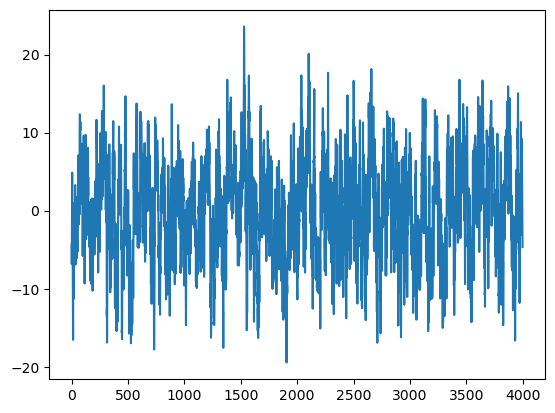

In [161]:
plot_this(cur_input[0,0,window-long:window+long].cpu().detach().numpy())

In [177]:
sig.shape

torch.Size([1, 22001])

In [176]:
sig[:,window:window+long].mean()

tensor(3.2223, device='cuda:3')

In [168]:
mm = sig_array[window:window+long].mean()
mm

tensor(3.2223)

In [169]:
np.sqrt(mm)

tensor(1.7951)

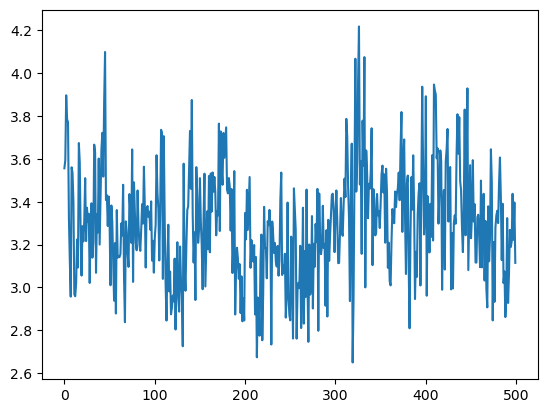

In [170]:
plot_this(sig_array[window:window+500].cpu().detach().numpy())

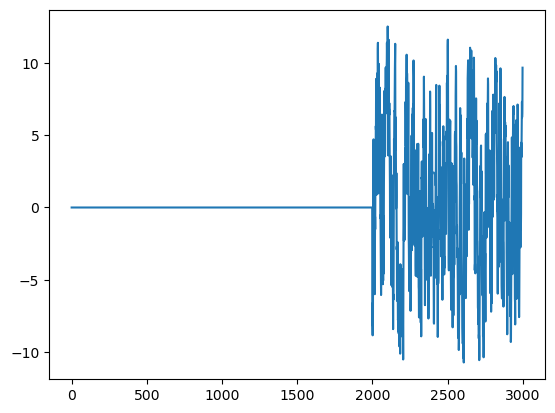

In [165]:
plot_this(mu_array[window-2000:window+1000].cpu().detach().numpy())

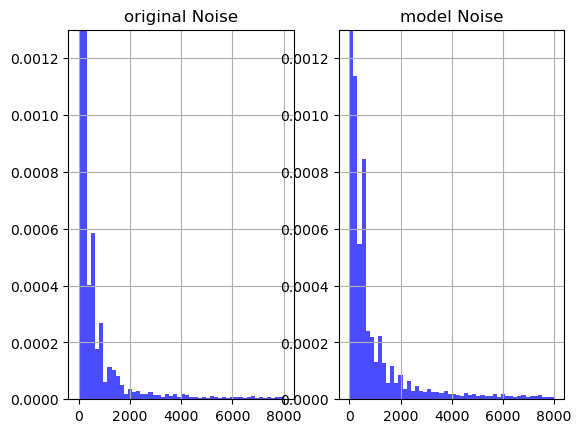

In [166]:

freqs1, magnitudes1 = signal.welch(train_inputs[0,0,window:window+long].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(cur_input[0,0,window:window+long].squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

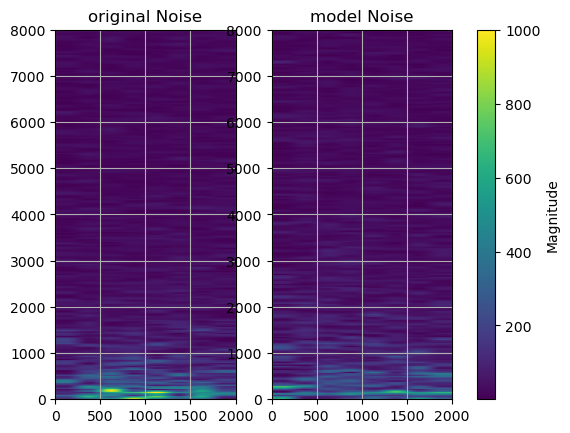

In [167]:
compare_spectrograms(train_inputs[0,0,window:window+long].detach().squeeze().cpu(),cur_input[0,0,window:window+long].detach().squeeze().cpu())

In [172]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

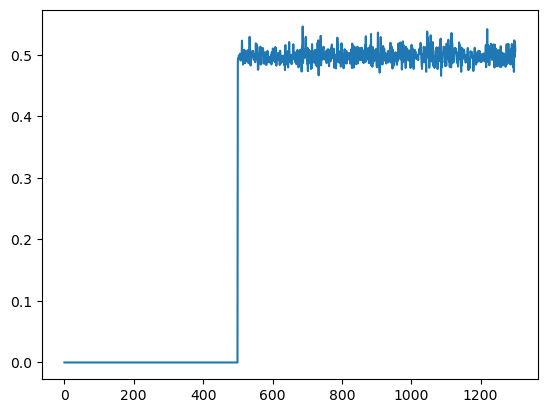

In [34]:
plot_this((sig_array4[window-500:window+2000]).cpu().detach().numpy())

In [49]:
sig_array4[window-2:window+4]

tensor([0.0000, 0.0000, 0.5208, 0.5295, 0.5330, 0.5224],
       grad_fn=<SliceBackward0>)

In [50]:
train_inputs4[0,0,window+4990:window+5000]

tensor([ 1.8934, -1.1883,  1.8217, -1.7287,  0.9667, -0.4488,  1.8015, -1.4541,
         0.9176, -0.3599], device='cuda:1')

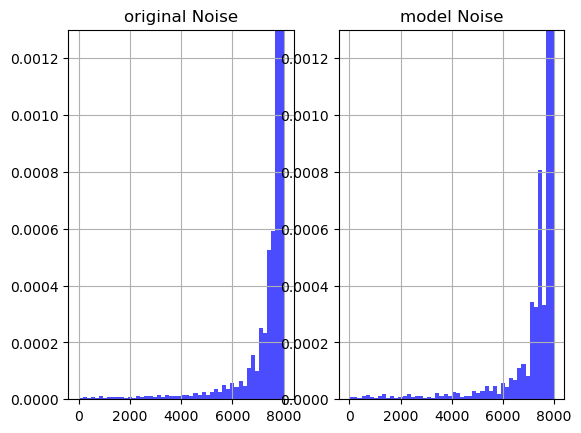

In [37]:
freqs1, magnitudes1 = signal.welch(train_inputs4[0,0,window:window+5000].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(cur_input4[0,0,window:window+5000].squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

In [36]:
with torch.no_grad():
    output_test_low_mean, output_test_low_std = (model4(train_inputs4, gt_test))
audio_output = torch.normal(output_test_low_mean, output_test_low_std).squeeze()

freqs1, magnitudes1 = signal.periodogram(train_inputs4[0,:].squeeze()[400:].cpu().numpy(), fs=16000)
freqs, magnitudes = signal.periodogram(audio_output[0,:].squeeze()[400:].cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

IndexError: too many indices for tensor of dimension 1

In [50]:
output_test_low_std.shape

torch.Size([8, 16000])

(array([5.000e+00, 1.000e+00, 1.400e+01, 1.900e+01, 4.800e+01, 6.800e+01,
        1.270e+02, 2.090e+02, 3.170e+02, 4.110e+02, 6.030e+02, 7.210e+02,
        8.790e+02, 1.032e+03, 1.123e+03, 1.117e+03, 1.257e+03, 1.192e+03,
        1.064e+03, 1.045e+03, 9.710e+02, 7.700e+02, 6.920e+02, 5.550e+02,
        4.840e+02, 3.150e+02, 2.510e+02, 1.940e+02, 1.450e+02, 1.130e+02,
        7.400e+01, 5.700e+01, 4.000e+01, 2.400e+01, 1.300e+01, 1.200e+01,
        8.000e+00, 6.000e+00, 9.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.36030853, 0.36904621, 0.37778389, 0.38652158, 0.39525926,
        0.40399694, 0.41273463, 0.42147231, 0.43020999, 0.43894768,
        0.44768536, 0.45642304, 0.46516073, 0.47389844, 0.48263612,
        0.49137381, 0.50011146, 0.50884914, 0.51758683, 0.52632451,
        0.53506219, 0.54379988, 0.55253756, 0.56127524, 0.57001293,
        0.57875061, 0.58748835, 0.59

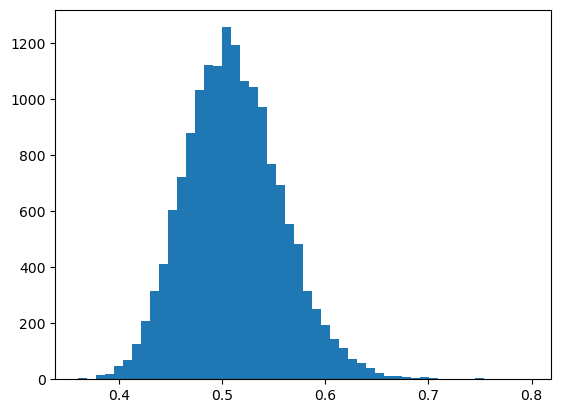

In [53]:
plt.hist(output_test_low_std[0,:].cpu(),bins=50)

In [ ]:
audio_output.shape

torch.Size([8, 560000])

In [191]:
from torch import nn



class SimpleAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(0.1))  # Initial value of 'a'
        self.b = nn.Parameter(torch.tensor(0.1))  # Initial value of 'b'
        # self.c = nn.Parameter(torch.tensor(0.1)) 
        # self.d = nn.Parameter(torch.tensor(0.1)) 

    def forward(self, x, cur_gt):
        means = torch.zeros_like(x)
        stds = torch.zeros_like(x)
        for i in range(x.shape[-1]):
            if i==1 or i==0:
                continue
            means[:,:,i] = self.a* x[:,:,i-1]#+self.d* x[:,:,i-2] +self.c
            stds[:,:,i] = self.b 
        return means, stds
    
    def forward_once(self, x, cur_gt):
        means = self.a* x[:,:,i-1]# +self.d* x[:,:,i-2] +self.c
        stds = self.b 
        return means, stds
    
    def calc_model_likelihood(self, expected_means, expected_stds, wav_tensor, verbose=False):
        wav_tensor = wav_tensor.squeeze(axis=1)[:,3:]
        means_=expected_means.squeeze(axis=1)[:,3:]
        stds_ = expected_stds.squeeze(axis=1)[:,3:]


        exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
        param_all = 1/(np.sqrt(2*np.pi)*stds_)
        model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
        model_likelihood2 = torch.sum(exp_all, axis=-1) 

        if verbose:
            print("model_likelihood1: ", model_likelihood1)
            print("model_likelihood2: ", model_likelihood2)
        return model_likelihood1 + model_likelihood2
    
    def casual_loss(self, expected_means, expected_stds, wav_tensor):
        model_likelihood = self.calc_model_likelihood(expected_means, expected_stds, wav_tensor)
        return -model_likelihood   
    

In [192]:
train_full_tensors.shape

torch.Size([256, 560000])

start 


/tmp/ipykernel_147609/174528573.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(epochs)):


  0%|          | 0/30 [00:00<?, ?it/s]

0
Model 0 Epoch 30/30, Loss: 156963.8955078125, test Loss: 9749.388671875
480


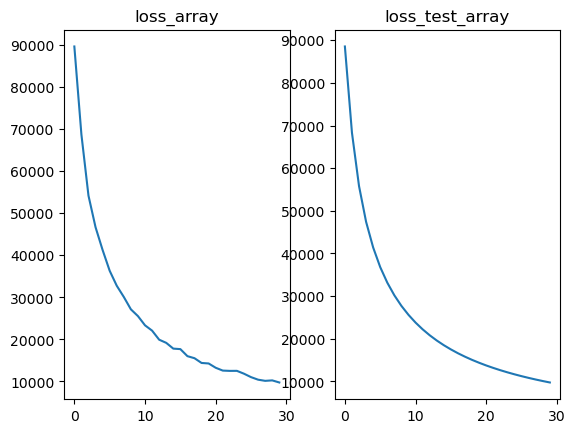

In [194]:
import torch.optim as optim
nets_g = [SimpleAR()]
epochs = 30

loss_array = {}
loss_test_array = {}
i=0
# train_full_tensors_n, mean, std = normalize_tensor(train_full_tensors)
# test_full_tensors_n, mean, std = normalize_tensor(test_full_tensors)
train_dataset = BatchNoiseDataset(train_full_tensors[:,:3000].reshape(dataset_size,1,-1),g_t[i])
test_dataset = BatchNoiseDataset(test_full_tensors[:,:3000].reshape(dataset_size,1,-1),g_t[i])

#Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True) #todo: numbers
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)


nets_g,loss_array_high,loss_test_array_high = train(steps=[0],nets=nets_g,train_loader=train_loader,test_loader=test_loader)

plot_loss(loss_array_high,loss_test_array_high,0)

In [195]:
model5 = nets_g[0]
model5.eval()
for batch_idx, (train_inputs4, gt_test) in enumerate(train_loader):
    break
# test_inputs, gt_test = test_dataset.__getitem__(j)
train_inputs4 = train_inputs4.to("cuda:1", dtype=torch.float)

In [196]:
# loss = model5.casual_loss( output_test_low_mean.to("cuda:1"), output_test_low_std.to("cuda:1"), train_inputs4).mean() ##.mean()

In [197]:
loss

NameError: name 'loss' is not defined

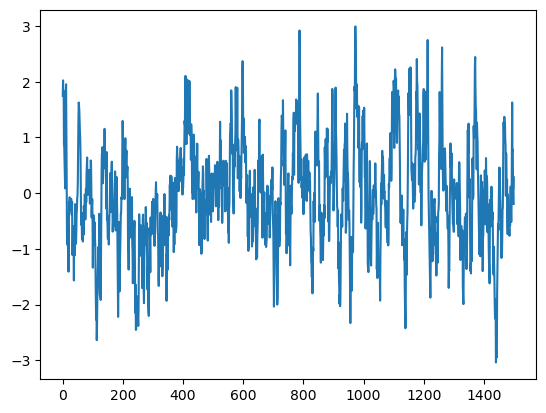

In [198]:
plot_this(cur_input4[0,0,window-500:window+1000].cpu().detach().numpy())

In [199]:
long = 999
window = 1000
mu_array4 = torch.zeros((long+window+1))
sig_array4 = torch.zeros((long+window+1))

model5 = model5.to("cuda:1")
cur_input4 = train_inputs4[0,0,:3000].clone().view(1,1,-1)
cur_input4[0,0,window+1:] = 0
print(cur_input4[0,0,window])
print(cur_input4[0,0,window+1])
cur_input4 = cur_input4.to("cuda:1", dtype=torch.float)
print(cur_input4.shape)
# cur_input = cur_train[0,0,:window].view(1,1,-1)
for i in tqdm(range(long)):
    if i >long:
        continue

    mu,sig = model5.forward_once(cur_input4[0,0,:window+i+1].view(1,1,-1),g_t[j])
    mu_ = mu[0,-1]
    sig_ = sig
    
    mu_array4[window+i] = mu_
    sig_array4[window+i] = sig_
    added = torch.normal(mu_.cpu(), sig_.cpu())#.reshape(1,1,1)
    # print(mu_,sig_,added)
    cur_input4[0,0,window+i+1] = added

    torch.cuda.empty_cache()

tensor(0.6467, device='cuda:1')
tensor(0., device='cuda:1')
torch.Size([1, 1, 3000])


/tmp/ipykernel_147609/615584594.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(long)):


  0%|          | 0/999 [00:00<?, ?it/s]

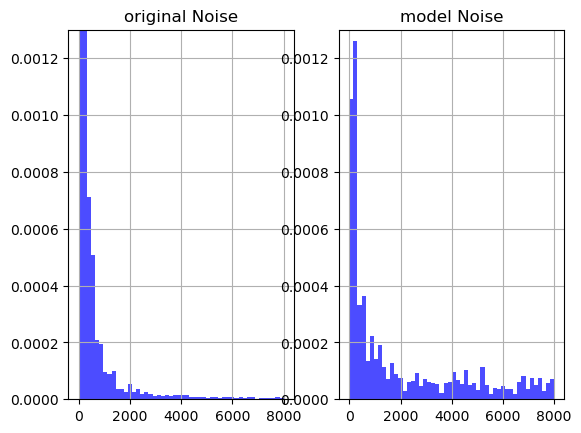

In [200]:
freqs1, magnitudes1 = signal.welch(train_inputs4[0,0,window:window+5000].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(cur_input4[0,0,window:window+5000].squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

In [201]:
for name, param in nets_g[0].named_parameters():
    if param.requires_grad:
        print(name, param.data)

a tensor(0.3514, device='cuda:1')
b tensor(0.2607, device='cuda:1')


In [ ]:
#LMS

In [49]:

batch_size_ = 1
order=1
white_noise = torch.normal(0, 1, size=(1, 5001))

# Expand AR coefficients for batch processing
ar_coefs = 0.9  # Shape: (batch_size, order)


# Initialize the AR noise tensor
ar_noise_ = torch.zeros_like(white_noise)

# Iterate across time steps to compute AR noise
for t in range(1, 5001):
    past_values = ar_noise_[:, t - 1:t]  # Shape: (batch_size, order)
    # Compute AR noise using matrix multiplication
    ar_noise_[:, t] = (past_values * ar_coefs).sum(dim=1) + white_noise[:, t]

# Remove the first `order` values to discard transient
ar_noise_ =  ar_noise_[:, order:]

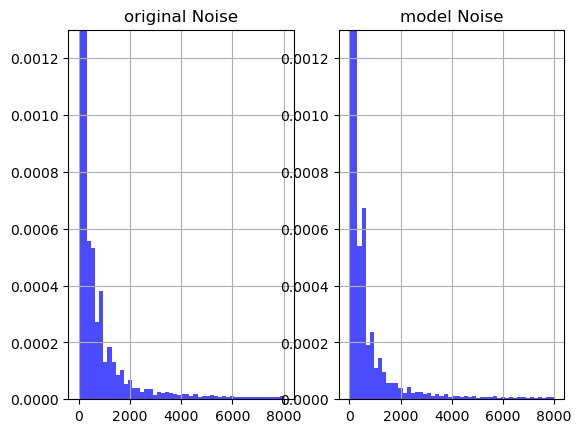

In [51]:
freqs1, magnitudes1 = signal.welch(train_inputs4[0,0,window:window+5000].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(ar_noise_.squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()